Notebook for ...

In [335]:
%reset -f
%matplotlib inline

In [336]:
import numpy as np
import scipy.io as sio
import sklearn as sk
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd

import datetime

from scipy.io import savemat
import pickle

from scipy import signal
from sklearn.grid_search import ParameterGrid

from cycling_rnn import *

In [337]:
cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
sns.set_palette(cmap)

In [338]:
def make_pairgrid(d):
    ''' in: (d1,d2,d3,d4) '''
    df = pd.DataFrame(np.concatenate(d))
    cond_labels = d[0].shape[0]*['fw1'] + d[1].shape[0]*['fw2'] + d[2].shape[0]*['bw1'] + d[3].shape[0]*['bw2']
    df['condition'] = cond_labels
    g = sns.PairGrid(df, hue='condition', diag_sharey=True)
    g.map_diag(plt.hist)
    g.map_offdiag(plt.plot)
    dmax = np.max(np.concatenate(d))
    g.add_legend()
    return g

In [343]:
monkey='C'

In [344]:
if monkey=='D':
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/drakeFeb.mat')
else:
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/cousFeb.mat')

In [345]:
emg = preprocess_array(data['D'][0, 0]['EMG'])
m1 = preprocess_array(data['D'][0, 0]['M1'], alpha=5)

time_axis, time_inds1, time_inds2 = get_time_axis(data['D'][0, 0]['KIN'])

emg = emg[time_axis]
m1 = m1[time_axis]

In [346]:
sio.savemat('cousFeb_processed.mat', mdict={'M1': m1, 'EMG': emg})


### load stuff

In [333]:
pth = './saves/0822-1343-02/'
x_tf = np.load(pth+'npsaves/x.npy')
y_tf = np.load(pth+'npsaves/y.npy')
param_grid = pickle.load(open(pth+'npsaves/param_grid.pickle'))
print x_tf.shape

(1, 1, 1, 2, 1)


In [334]:
param_grid

{'activation': [<function tensorflow.python.ops.math_ops.tanh>],
 'beta1': [0],
 'beta2': [0],
 'monkey': ['D', 'C'],
 'num_neurons': [100]}

In [277]:
for ii in range(x_tf.size):
    param_inds = np.unravel_index(ii, x_tf.shape)
    x_tf[param_inds] = x_tf[param_inds][:emg.shape[0],:emg.shape[1],:]
    y_tf[param_inds] = y_tf[param_inds][:emg.shape[0],:emg.shape[1],:]

### plot stuff

In [278]:
sns.set_context('paper', font_scale=1.5)

In [279]:
ii = 1
param_inds = np.unravel_index(ii, x_tf.shape)

In [282]:
param_grid

{'activation': [<function tensorflow.python.ops.math_ops.tanh>],
 'beta1': [0],
 'beta2': [0],
 'monkey': ['D', 'C'],
 'num_neurons': [100]}

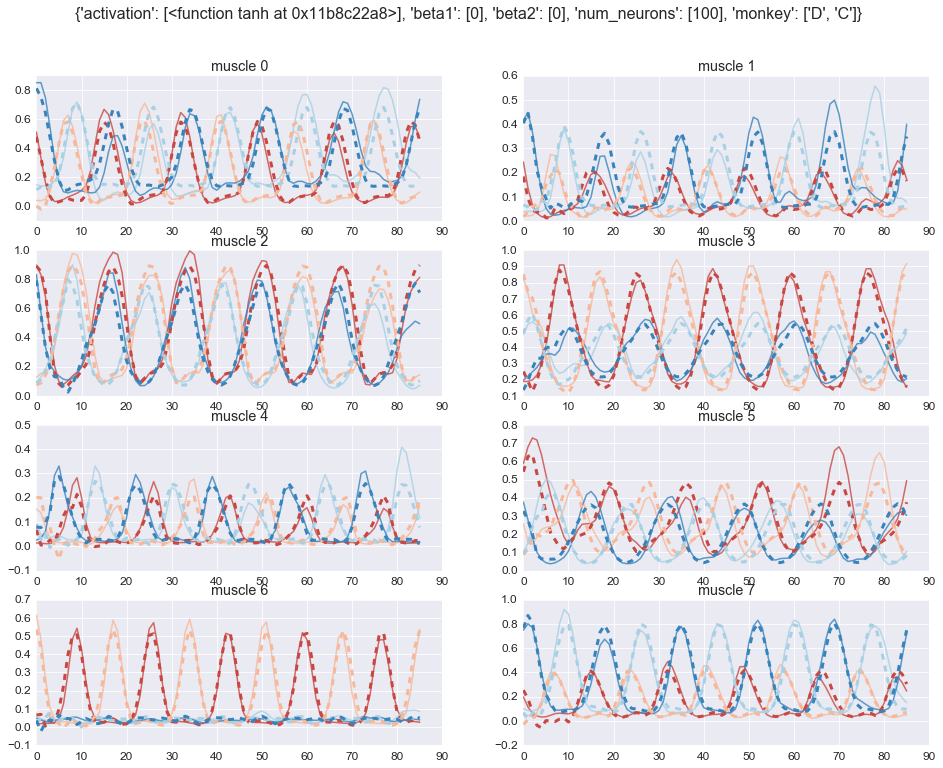

In [283]:
rows = 4
cols = 2

with sns.color_palette(n_colors=4):
    f, ax = plt.subplots(rows,cols, figsize=(16, 12))
    for i in range(rows):
        for j in range(cols):
            muscle = np.ravel_multi_index((i,j), (rows,cols))
            ax[i,j].plot(emg[:,:,muscle], linewidth=1.5, alpha=.8)
            ax[i,j].plot(y_tf[param_inds][:,:,muscle],'--',linewidth=3, alpha=1)
            ax[i,j].set_title('muscle '+str(muscle))
f.suptitle(param_grid, fontsize=16)
plt.show()

## RNN neuron PC plots

In [284]:
pca_x = sk.decomposition.PCA(n_components=5)
pca_y = sk.decomposition.PCA(n_components=5)

pca_x.fit(np.concatenate([x_tf[param_inds][:,i,:] for i in range(4)]))
pca_y.fit(np.concatenate([y_tf[param_inds][:,i,:] for i in range(4)]))

PCA(copy=True, n_components=5, whiten=False)

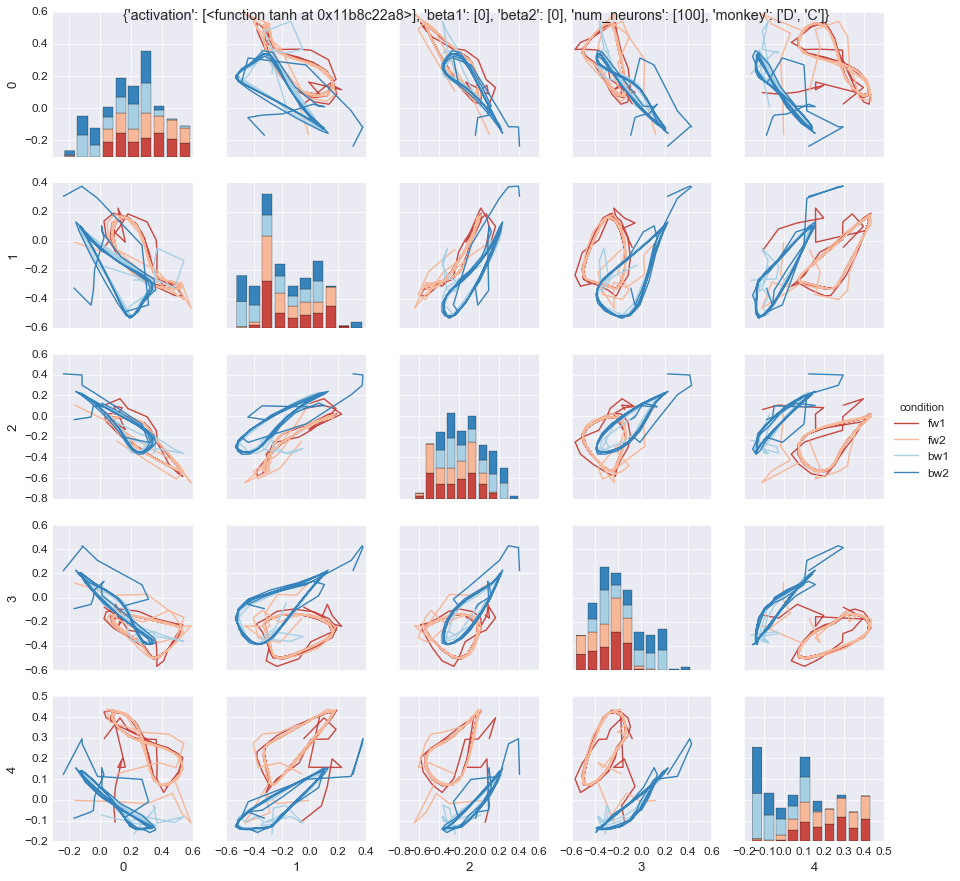

In [285]:
# plot PCs for the RNN state variable
f = make_pairgrid([np.dot(x_tf[0,0,0,0,0][:,i,:], pca_x.components_.T) for i in range(4)])
f.fig.suptitle(param_grid)

In [156]:
f.savefig('blah.pdf')

## RNN activations

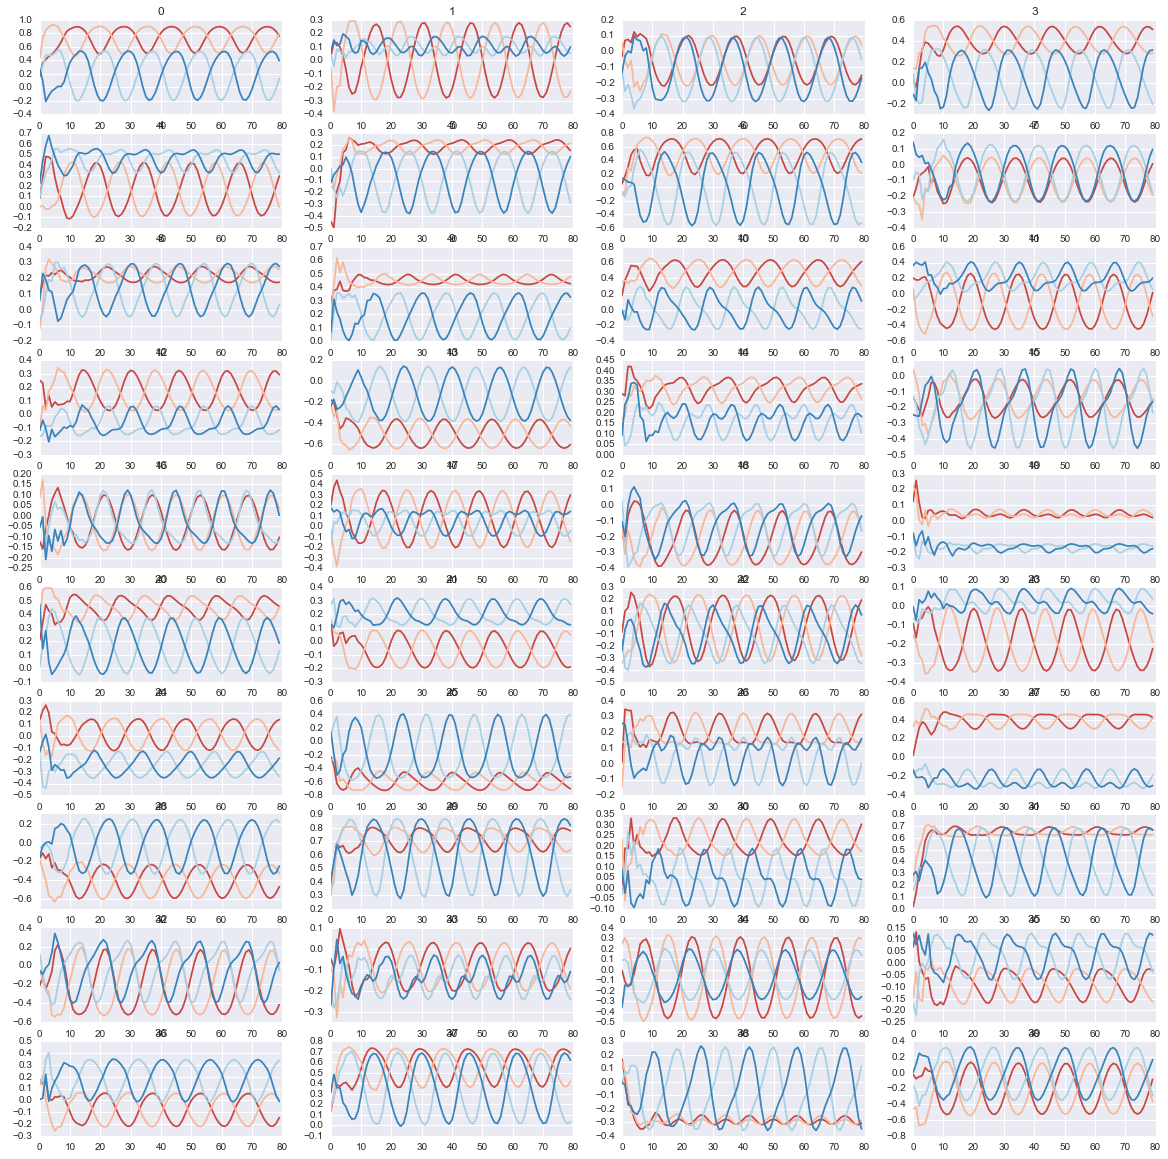

In [93]:
rows = 10
cols = 4
f, ax = plt.subplots(rows,cols, figsize=(20,20))

for i in range(rows):
    for j in range(cols):
        neuron = np.ravel_multi_index((i,j), (rows,cols))
        ax[i,j].plot(x_tf[param_inds][:,:,neuron])
        ax[i,j].set_title(str(neuron))
plt.show()

### load model

In [ ]:
hp_pf = '%02d_%02d' % (ii,jj)
pth+'tfsaves/'+hp_pf

In [286]:
pth+'tfsaves/'

'./saves/0822-1343-02/tfsaves/'

In [295]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
new_saver = tf.train.import_meta_graph(pth+'tfsaves/1.meta')
new_saver.restore(sess, pth+'tfsaves/1')
    # tf.get_collection() returns a list. In this example we only want the
    # first one.
    
    #train_op = tf.get_collection('train_op')[0]
    #for step in xrange(1000000):
    #sess.run(train_op)

In [321]:
[v.name for v in tf.all_variables()]

[u'x0:0',
 u'C:0',
 u'd:0',
 u'RNN/BasicRNNCell/Linear/Matrix:0',
 u'RNN/BasicRNNCell/Linear/Bias:0',
 u'beta1_power:0',
 u'beta2_power:0',
 u'x0/Adam:0',
 u'x0/Adam_1:0',
 u'C/Adam:0',
 u'C/Adam_1:0',
 u'd/Adam:0',
 u'd/Adam_1:0',
 u'RNN/BasicRNNCell/Linear/Matrix/Adam:0',
 u'RNN/BasicRNNCell/Linear/Matrix/Adam_1:0',
 u'RNN/BasicRNNCell/Linear/Bias/Adam:0',
 u'RNN/BasicRNNCell/Linear/Bias/Adam_1:0']

In [320]:
[v.get_shape() for v in tf.all_variables()]

[TensorShape([Dimension(12), Dimension(100)]),
 TensorShape([Dimension(100), Dimension(22)]),
 TensorShape([Dimension(1), Dimension(22)]),
 TensorShape([Dimension(102), Dimension(100)]),
 TensorShape([Dimension(100)]),
 TensorShape([]),
 TensorShape([]),
 TensorShape([Dimension(12), Dimension(100)]),
 TensorShape([Dimension(12), Dimension(100)]),
 TensorShape([Dimension(100), Dimension(22)]),
 TensorShape([Dimension(100), Dimension(22)]),
 TensorShape([Dimension(1), Dimension(22)]),
 TensorShape([Dimension(1), Dimension(22)]),
 TensorShape([Dimension(102), Dimension(100)]),
 TensorShape([Dimension(102), Dimension(100)]),
 TensorShape([Dimension(100)]),
 TensorShape([Dimension(100)])]

In [332]:
Mat.shape[0]-Mat.shape[1]

2

In [323]:
Mat = sess.run([v for v in tf.all_variables() if v.name == 'RNN/BasicRNNCell/Linear/Matrix:0'])[0]
A = Mat[2:]
B = Mat[:2]

In [313]:
def plot_eigs(A_mat):
  """
    Docstring
  """
  w, _ = np.linalg.eig(A_mat)
  re_w = np.real(w)
  im_w = np.imag(w)
  f = plt.figure(figsize=(5, 5))
  plt.plot(re_w, im_w, 'o', alpha=0.9)
  theta = np.linspace(0, 2*np.pi, num=50)
  x_cir = np.cos(theta)
  y_cir = np.sin(theta)
  plt.plot(x_cir, y_cir, 'k', linewidth=0.5, alpha=0.5)
  plt.plot([-100, 100], [0, 0], 'k', linewidth=0.5, alpha=0.5)
  plt.plot([0, 0], [-100, 100], 'k', linewidth=0.5, alpha=0.5)
  plt.xlim([-1.5, 1.5])
  plt.ylim([-1.5, 1.5])
  return f

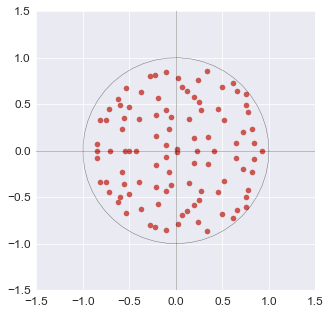

In [314]:
f = plot_eigs(A)